In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
train_data = pd.read_csv('./Data/train.csv')

In [35]:
train_data

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [136]:
train_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [71]:
train_data.tweet.apply(lambda x: len(x)).describe().rename('tweet_length')

count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: tweet_length, dtype: float64

<Axes: xlabel='tweet_length'>

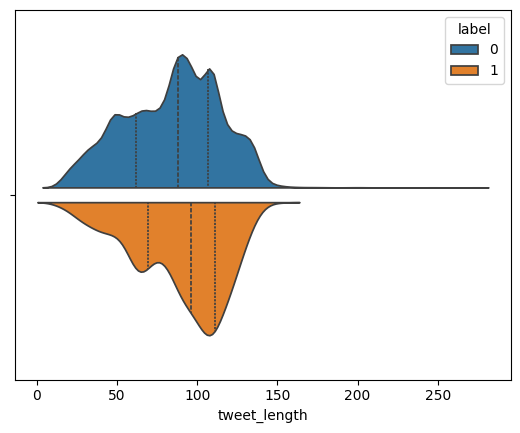

In [138]:
sns.violinplot(
    data=pd.concat([train_data.label, train_data.tweet.apply(lambda x: len(x)).rename('tweet_length')], axis=1),
    x='tweet_length', hue='label', inner='quart', split=True, gap=.1)

In [139]:
train_data.tweet.apply(lambda x: len(x)).value_counts(normalize=False)

tweet
109    839
86     750
108    528
95     528
91     478
      ... 
247      1
155      1
199      1
172      1
201      1
Name: count, Length: 165, dtype: int64

In [6]:
train_data.shape

((31962, 3), (17197, 2))

In [7]:
train_data.label.value_counts(normalize=True)

label
0    0.929854
1    0.070146
Name: proportion, dtype: float64

### Предобработка данных

Для лучшей работы алгоритмов необходимо **привести все слова к нижнему регистру** (под капотом **Vectorizer**), **удалить все знаки препинания** (под капотом **Vectorizer**), **добавить стоп-слова** и **застеммить данные**

In [9]:
import nltk

nltk.download("stopwords", quiet=True)

True

In [10]:
from nltk.corpus import stopwords

stopWords = stopwords.words('english')
stopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Строим векторы признаков

Смореть в презентации - [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [11]:
CV = CountVectorizer(stop_words=stopWords, lowercase=True, ngram_range=(1, 3), binary=False)
CV_X = CV.fit_transform(train_data.tweet)

In [12]:
CV.get_feature_names_out()

array(['00', '00 13', '00 13 00', ..., 'øª', 'ø¹ù', 'ø¹ù user'],
      dtype=object)

In [62]:
TFV = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1, 3), binary=False)
TFV_X = TFV.fit_transform(train_data.tweet)

In [14]:
TFV.get_feature_names_out()

array(['00', '00 13', '00 13 00', ..., 'øª', 'ø¹ù', 'ø¹ù user'],
      dtype=object)

### Создаём train-test выборки

In [15]:
CV_X_train, CV_X_test, CV_y_train, CV_y_test = train_test_split(CV_X, train_data.label,
                                                                test_size=0.2, shuffle=True,
                                                                stratify=train_data.label)

In [16]:
TFV_X_train, TFV_X_test, TFV_y_train, TFV_y_test = train_test_split(TFV_X, train_data.label,
                                                                    test_size=0.2, shuffle=True,
                                                                    stratify=train_data.label)

### [ComplementNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html)

ComplementNB implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights. 

In [17]:
CV_CompNB = ComplementNB()
CV_CompNB.fit(CV_X_train, CV_y_train)
print(classification_report(CV_CompNB.predict(CV_X_test), CV_y_test,
                            target_names=['Neutral', 'Negative']))

              precision    recall  f1-score   support

     Neutral       0.82      0.99      0.90      4939
    Negative       0.87      0.27      0.41      1454

    accuracy                           0.82      6393
   macro avg       0.84      0.63      0.65      6393
weighted avg       0.83      0.82      0.79      6393



In [18]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('neutral', 'negative')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))


show_top(CV_CompNB, CV, 20)

neu: go exhibition opens go exhibition go euros gone go euros go euro2016 eng go euro2016 go estate sale go estate go ercanairpo badday go ercanairpo go enjoy go engrus ½ï go engrus go ended kind go ended go effected shooting go effected go eddie family go follow stream ø¹ù user
neg: email saying blocked email times email times missing email today said em week running world cup emailed user emailed user february running unopposed still running unopposed emails know emails know redemption running training friends running training running tomorrow may running tomorrow running together ready running together running world ø¹ù user


In [19]:
TFV_CompNB = ComplementNB()
TFV_CompNB.fit(TFV_X_train, TFV_y_train)
print(classification_report(TFV_CompNB.predict(TFV_X_test), TFV_y_test,
                            target_names=['Neutral', 'Negative']))

              precision    recall  f1-score   support

     Neutral       0.94      0.98      0.96      5698
    Negative       0.70      0.45      0.55       695

    accuracy                           0.92      6393
   macro avg       0.82      0.71      0.75      6393
weighted avg       0.91      0.92      0.91      6393



In [20]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('neutral', 'negative')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))


show_top(TFV_CompNB, TFV, 20)

neu: yum july family friends tool healing altwaystoheal tool healing mountains reached singer gig holding shoot bouncingbaby warm user weekend therapy tool therapy tool healing nursery rhymes headed bihdaygirl friend astrologer love amazing health benefits
neg: time customers time dialed hell lose hell lose god development class beachbody beach removes gators wildlife removes validity removes validity point just saw play beachbody beach fit childhood coin user remylacroix hell remain beachbrighton time date let time date time customers order time crisis point nonprofits


### [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors $ \theta_y = (\theta_{y1},\ldots,\theta_{yn}) $ for each class y, where n is the number of features (in text classification, the size of the vocabulary) and $ \theta_{yi} $ is the probability $ P(x_i \mid y) $  of feature i appearing in a sample belonging to class y.

The parameters $ \theta_y $ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:  
$ \hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n} $  
 where $ N_{yi} = \sum_{x \in T} x_i $ is the number of times feature i appears in a sample of class y in the training set T, and $ N_{y} = \sum_{i=1}^{n} N_{yi} $ is the total count of all features for class y.

The smoothing priors $ \alpha \ge 0 $ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $ \alpha = 0 $ is called Laplace smoothing, while $ \alpha < 0 $ is called Lidstone smoothing

In [21]:
CV_MultiNB = MultinomialNB(alpha=1)
CV_MultiNB.fit(CV_X_train, CV_y_train)
print(classification_report(CV_MultiNB.predict(CV_X_test), CV_y_test,
                            target_names=['Neutral', 'Negative']))

              precision    recall  f1-score   support

     Neutral       0.90      0.98      0.94      5464
    Negative       0.79      0.38      0.51       929

    accuracy                           0.90      6393
   macro avg       0.85      0.68      0.73      6393
weighted avg       0.89      0.90      0.88      6393



In [22]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('neutral', 'negative')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))


show_top(CV_MultiNB, CV, 20)

neu: one see people bihday good get thankful positive like new today time life amp user user user happy day love user user user
neg: sjw new might women obama liberal people user allahsoil politics allahsoil racist black white like libtard user user user trump amp user user user


In [23]:
TFV_MultiNB = MultinomialNB(alpha=1)
TFV_MultiNB.fit(TFV_X_train, TFV_y_train)
print(classification_report(TFV_MultiNB.predict(TFV_X_test), TFV_y_test,
                            target_names=['Neutral', 'Negative']))

              precision    recall  f1-score   support

     Neutral       1.00      0.94      0.97      6335
    Negative       0.13      1.00      0.23        58

    accuracy                           0.94      6393
   macro avg       0.56      0.97      0.60      6393
weighted avg       0.99      0.94      0.96      6393



In [24]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('neutral', 'negative')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))


show_top(TFV_MultiNB, TFV, 20)

neu: love time time urð love time urð model love time urð model love today model amp life just happy time positive user user user thankful day love user user user
neg: allahsoil racist black libtard sjw libtard libtard sjw libtard libtard libtard sjw liberal liberal politics sjw liberal politics sjw liberal white sjw liberal politics user user user amp trump libtard user user user


### Попробуем воспользоваться ADASYN (over_sampling) для TFV

In [48]:
ad = ADASYN()  # SMOTE + погрешность вне прямой между точками
TFV_X_train_AD, TFV_y_train_AD = ad.fit_resample(TFV_X_train, TFV_y_train)
TFV_X_test_AD, TFV_y_test_AD = ad.fit_resample(TFV_X_test, TFV_y_test)  # не имеет смысла, тк это test

In [46]:
TFV_CompNB_AD = ComplementNB()
TFV_CompNB_AD.fit(TFV_X_train_AD, TFV_y_train_AD)
print(classification_report(TFV_CompNB_AD.predict(TFV_X_test), TFV_y_test,
                            target_names=['Neutral', 'Negative']))

              precision    recall  f1-score   support

     Neutral       0.88      0.99      0.93      5304
    Negative       0.87      0.36      0.51      1089

    accuracy                           0.88      6393
   macro avg       0.88      0.67      0.72      6393
weighted avg       0.88      0.88      0.86      6393



In [47]:
TFV_MultiNB_AD = MultinomialNB(alpha=1)
TFV_MultiNB_AD.fit(TFV_X_train_AD, TFV_y_train_AD)
print(classification_report(TFV_MultiNB_AD.predict(TFV_X_test), TFV_y_test,
                            target_names=['Neutral', 'Negative']))

              precision    recall  f1-score   support

     Neutral       0.88      0.99      0.93      5297
    Negative       0.87      0.36      0.51      1096

    accuracy                           0.88      6393
   macro avg       0.88      0.67      0.72      6393
weighted avg       0.88      0.88      0.86      6393



### CatBoost

In [53]:
CB_pipe = Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                          ('cb', CatBoostClassifier())])
CB_pipe.fit(TFV_X_train, TFV_y_train)
print(classification_report(CB_pipe.predict(TFV_X_test), TFV_y_test))

Learning rate set to 0.041118
0:	learn: 0.6487289	total: 971ms	remaining: 16m 10s
1:	learn: 0.6088625	total: 1.8s	remaining: 14m 56s
2:	learn: 0.5731369	total: 2.57s	remaining: 14m 14s
3:	learn: 0.5403480	total: 3.42s	remaining: 14m 10s
4:	learn: 0.5109645	total: 4.22s	remaining: 13m 59s
5:	learn: 0.4837034	total: 5.04s	remaining: 13m 55s
6:	learn: 0.4591269	total: 5.85s	remaining: 13m 49s
7:	learn: 0.4378799	total: 6.59s	remaining: 13m 37s
8:	learn: 0.4180256	total: 7.49s	remaining: 13m 44s
9:	learn: 0.3993296	total: 8.42s	remaining: 13m 53s
10:	learn: 0.3839807	total: 9.24s	remaining: 13m 50s
11:	learn: 0.3689759	total: 9.99s	remaining: 13m 42s
12:	learn: 0.3548440	total: 10.8s	remaining: 13m 38s
13:	learn: 0.3424174	total: 11.7s	remaining: 13m 43s
14:	learn: 0.3296989	total: 12.4s	remaining: 13m 35s
15:	learn: 0.3192399	total: 13.2s	remaining: 13m 33s
16:	learn: 0.3104611	total: 14s	remaining: 13m 31s
17:	learn: 0.3021819	total: 14.9s	remaining: 13m 33s
18:	learn: 0.2947165	total: 1

### Предсказываем на неизвестном датасете 

In [74]:
test_data = pd.read_csv('./Data/test.csv')
TFV_X_experiment = TFV.transform(test_data.tweet)

In [75]:
TFV_CompNB_experiment_prediction = pd.Series(TFV_CompNB.predict(TFV_X_experiment))
print(TFV_CompNB_experiment_prediction.value_counts(normalize=True))

0    0.846194
1    0.153806
Name: proportion, dtype: float64


In [26]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# 
# 
# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0]  #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
#     sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#     return sum_embeddings / sum_mask
# 
# 
# #Sentences we want sentence embeddings for
# sentences = ['Привет! Как твои дела?',
#              'А правда, что 42 твое любимое число?']
# 
# #Load AutoModel from huggingface model repository
# tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
# model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")
# 
# #Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
# 
# #Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)
# 
# #Perform pooling. In this case, mean pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# print(sentence_embeddings)